# Visualization of incidence reports in San Francisco
Prepared by: Tasko Olevski  
Date: 12/24/2017

## Description
For this assignment I have decided to explore the correlation in the occurrence of different types of crimes in San Francisco. Therefore the data and plots below can be used to answer a question such as:

_'Which types of crime are correlated on a day to day basis in San Francisco?'_

The the crime category and date (excluding the time of day) are used in the charts below. The sections below just read the data in, align it in terms of the date and location, and count the occurrences.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats.stats import pearsonr
import itertools
import numpy as np

In [2]:
# Only 2 columns are used from the original data - category and date
data = pd.read_csv('sanfrancisco_incidents_summer_2014.csv', parse_dates=['Date'])

# This code aligns the data by location and date for easy plotting and correlation
plot_data = data.loc[:,['Date','Category']]\
    .groupby(['Date','Category'])\
    .size()\
    .rename('Counts')\
    .unstack('Category')\
    .sort_index()

## Plot 1
At this point one can plot a pair-wise correlation plot of the most commonly occurring types of offenses disregarding the location. The image below shows scatter plots of all combinations of the 5 most common crime types and the Pearson correlation coefficient. The value of the coefficient is 1.0 for a perfectly positive linear correlation and -1.0 for a negative linear correlation. A value of zero for the Pearson coefficient indicates that a linear correlation does not exist.

Two conclusions could be drawn from the plot below: 
- There aren't any strong linear correlations between the top 5 crimes as the values of all R coefficients are lower than 0.3 or higher than -0.3. 
- The strongest correlation of the 5 most frequently occurring crime types is between other offenses and warrants.

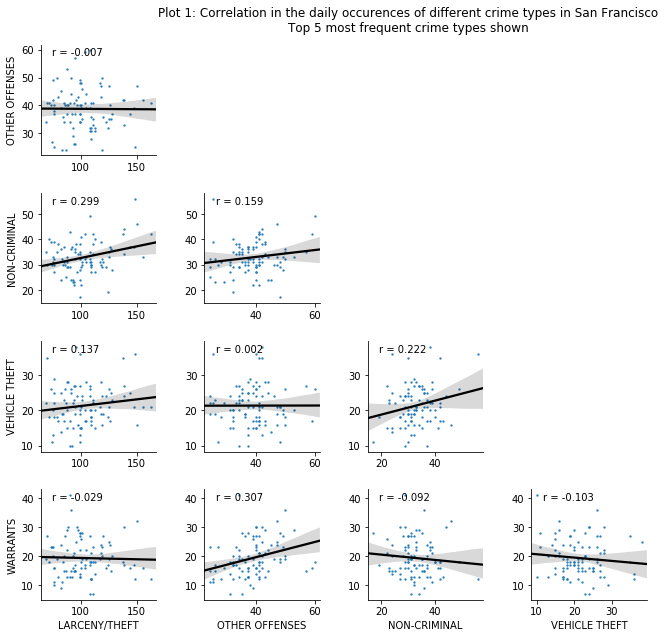

In [3]:
# Drop the dates because they are not needed to show up in the plots
# The data is already aligned by the date since the date was used as an index
plot_data_1=plot_data\
    .copy()\
    .reset_index(drop=True)\
    .fillna(0)
    
# Get the top 5 most common crimes
columns =list(plot_data_1.iloc[:,2:].sum(axis=0).sort_values(ascending=False).index.values[0:5]) \

# Function to annotate plots with pearson r
def show_r(x, y, **kws):
    pr, not_used = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.3f}".format(pr),
                xy=(.1, .9), xycoords=ax.transAxes)

# Plot pairwise correlation of top 5 crimes, hide upper right triangle
# Anotate plots with the pearson R values
plot1=sns.PairGrid(plot_data_1.loc[:,columns], size=1.8, aspect=1.3)
plot1.map_lower(sns.regplot, scatter_kws={'marker':'+','s':2}, line_kws={'color':'black'})
plot1.map_lower(show_r)
plot1.fig.subplots_adjust(top=1.15)
plot1.fig.suptitle('Plot 1: Correlation in the daily occurences of different crime types in San Francisco\nTop 5 most frequent crime types shown')
for i, j in zip(*np.triu_indices_from(plot1.axes, 1)):
    plot1.axes[i, j].set_visible(False)
for i in range(0,5): plot1.axes[i, i].set_visible(False)

## Plot 2
Plot 1 only focuses on 5 crime types, however it is possible that there are other crime types that occur less frequently yet  are well correlated. In order to explore this possibility I have constructed a chart of the R-values for all crime type combinations in San Francisco. One thing I noticed in constructing this chart is that some crime types occur repeatedly but the number of occurrence is always very low. Therefore a linear trend is very easy to fit to such crimes which have only 2-3 distinct daily occurrences. In my opinion this is not a true correlation and it occurs just as a result of chance and the nature of the data. To avoid such correlations I have added a condition in the code below such that the Pearson R coefficient is calculated only for crime type pairs that have 5 or more distinct values. This is one of the reasons that certain 'squares' of the chart below are white - this indicates that there were insufficient data for a meaningful correlation. Also the section below the diagonal of the Pearson R coefficient chart is white because these pairs would be repetitions. I assumed that the order of the crime types in the pairs is not important and therefore the section below the diagonal in the chart is blank.

The plot below shows a few things:
- There are crime types that tend to have positive correlation with pretty much all other crime types such as non-criminal, other offenses, suspicios occurrence and trespassing.
- Some crime types seem to have a negative correlation which means that on days when crime type A has a high occurrence crime type B has low chances of occurring.
- The crimes that tend to correlate negatively with other crime types are disorderly conduct, forgery/counterfeiting and runaway.

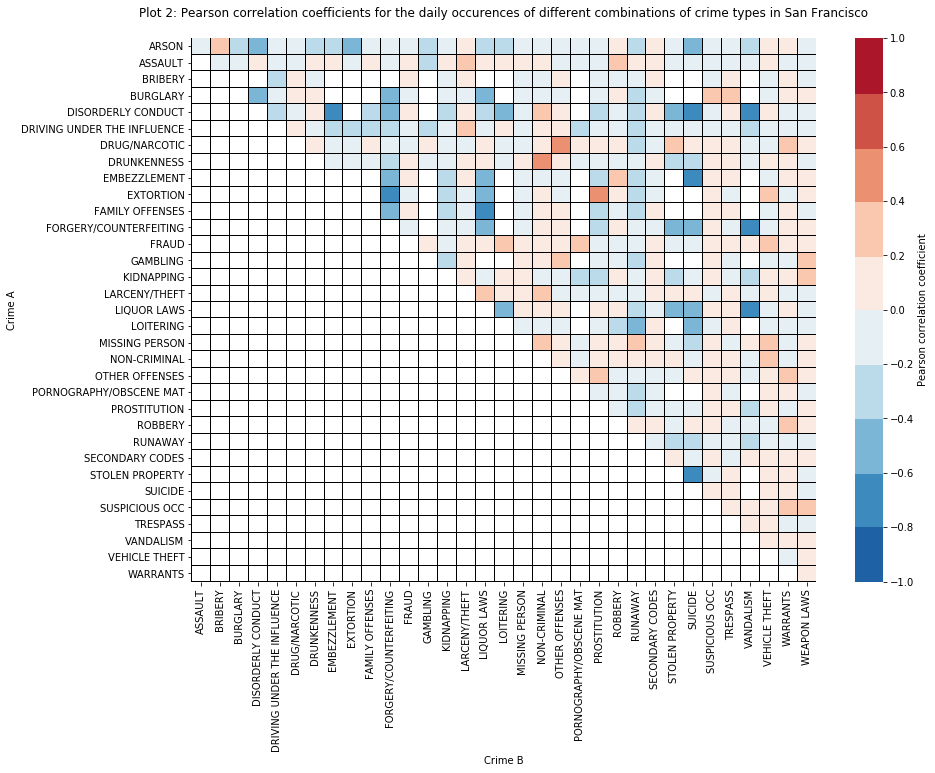

In [4]:
columns = plot_data.columns.values
r_values = []
# Calculate all pearson R coefficients for all combinations of crimes and for all locations
# Calculate the pearson R coefficient if there are only 5 or more distinct values
for col_a, col_b in itertools.combinations(columns, 2):
    r_data = plot_data.loc[:,[col_a,col_b]].copy().dropna(axis=0, how='all').fillna(0)
    if r_data.drop_duplicates().shape[0]>=5: 
        r_values.append((col_a,col_b,
            pearsonr(r_data.iloc[:,0].as_matrix(), 
                     r_data.iloc[:,1].as_matrix())[0]))

# Convert the R values in dataframe
RValues = pd.DataFrame.from_records(r_values, columns=['Crime A', 'Crime B' , 'R-value'])
RValues = RValues.set_index(['Crime A', 'Crime B']).unstack('Crime B')
RValues.columns = RValues.columns.droplevel()
plt.figure(figsize=(14,10))
plt.title('Plot 2: Pearson correlation coefficients for the daily occurences of different combinations\
 of crime types in San Francisco\n')
plot2 = sns.heatmap(RValues, 
            cmap=sns.color_palette("RdBu_r", 10), 
            center=0, 
            linecolor='black', linewidths=0.005, 
            vmin=-1.0, vmax=1.0,
            cbar_kws={"ticks":np.linspace(-1.0,1.0,11),
                     'label': 'Pearson correlation coefficient'
                     }
           )